In [5]:
import hklearn 
from hklearn import Stack
import joblib
import matplotlib.pyplot as plt
import numpy as np
from hklearn.transforms import LogRatioScaler
import hylite
import pandas as pd
from hycore import loadShed
from sklearn.metrics import r2_score
import os
from matplotlib.colorbar import Colorbar
from matplotlib.transforms import Bbox
import dill

In [6]:
#setup figure styles
import matplotlib as mpl
plt.style.use(['default'])
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
dipcmap = plt.get_cmap("RdYlGn_r")

### Load stack

Load the Stack object containing our data, and the associated dictionary of spectral indices and sample properties.

In [7]:
S = Stack.load('volcanoes.stack')
with open('indices.dill', 'rb') as f:
    indices = dill.load(f)

### Simple Methods

First, we train some relatively simple regression models (Lasso, PLSR, SVR), as implemented in scikit-learn.

In [8]:
# first we create a ModelSet object and bind our stack to it
from hklearn import ModelSet
M = ModelSet().bind(S)

***Lasso***

In [9]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso

In [10]:
np.random.seed(42) # for consistency

est = MultiOutputRegressor( Lasso() ) # build our regressor
n='uni_lasso_pca'
hyperparams = dict( # specify some hyperparameters to optimise
    estimator__alpha = [0.001, 0.01,0.1, 1,5,10],
)
best = M.fit_model(n, est, subset='fold', # use our folds for cross validation
                           gs=hyperparams, # do a gridsearch to find the best hyperparams
                           xtransform=True, # apply PCA transforms before fitting models
                           ytransform=True, # apply the transform we defined for our target variables
                           n_jobs=-1 ) # And.... use multiple threads!

# print the optimum hyperparameters
for k in hyperparams.keys():
    print("Best %s is %s"%(k, best['GridSearch_BestParams'][k] ))
print("------------------------------------")

print("\n5-fold CV score: %.2f"%best['kfold_score'])
for tn,r in zip( S.target_names, best['kfold_score_all'] ):
    print("\t%s (%.2f) "%(tn,r), end='')

Best estimator__alpha is 0.01
------------------------------------

5-fold CV score: 0.21
	density (0.39) 	porosity (0.33) 	UCS2_MPa (0.21) 	E_GPa (0.30) 

***PLSR***

In [11]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cross_decomposition import PLSRegression

In [13]:
np.random.seed(42) # for consistency

est = MultiOutputRegressor( PLSRegression() ) # build our regressor
n='uni_PLSR_pca'
hyperparams = dict( # specify some hyperparameters to optimise
    estimator__n_components = [5,10,15,20,25,30],
)
best = M.fit_model(n, est, subset='fold', # use our folds for cross validation
                           gs=hyperparams, # do a gridsearch to find the best hyperparams
                           xtransform=True, # apply PCA transforms before fitting models
                           ytransform=True, # apply the transform we defined for our target variables
                           n_jobs=-1 ) # And.... use multiple threads!

# print the optimum hyperparameters
for k in hyperparams.keys():
    print("Best %s is %s"%(k, best['GridSearch_BestParams'][k] ))
print("------------------------------------")

print("\n5-fold CV score: %.2f"%best['kfold_score'])
for tn,r in zip( S.target_names, best['kfold_score_all'] ):
    print("\t%s (%.2f) "%(tn,r), end='')

Best estimator__n_components is 20
------------------------------------

5-fold CV score: 0.17
	density (0.36) 	porosity (0.30) 	UCS2_MPa (0.16) 	E_GPa (0.28) 

In [14]:
np.random.seed(42) # for consistency

est = MultiOutputRegressor( PLSRegression() ) # build our regressor
n='uni_PLSR_pca'
hyperparams = dict( # specify some hyperparameters to optimise
    estimator__n_components = [5,10,15,20,25,30],
)
best = M.fit_model(n, est, subset='fold', # use our folds for cross validation
                           gs=hyperparams, # do a gridsearch to find the best hyperparams
                           xtransform=False, # apply PCA transforms before fitting models
                           ytransform=True, # apply the transform we defined for our target variables
                           n_jobs=-1 ) # And.... use multiple threads!

# print the optimum hyperparameters
for k in hyperparams.keys():
    print("Best %s is %s"%(k, best['GridSearch_BestParams'][k] ))
print("------------------------------------")

print("\n5-fold CV score: %.2f"%best['kfold_score'])
for tn,r in zip( S.target_names, best['kfold_score_all'] ):
    print("\t%s (%.2f) "%(tn,r), end='')

Best estimator__n_components is 10
------------------------------------

5-fold CV score: 0.19
	density (0.51) 	porosity (0.48) 	UCS2_MPa (0.18) 	E_GPa (0.36) 

***Support vector machines***

In [5]:
from sklearn.multioutput import MultiOutputRegressor

In [6]:
np.random.seed(42) # for consistency
from sklearn.svm import SVR

est = MultiOutputRegressor( SVR() ) # build our regressor
n='uni_svr_pca'
hyperparams = dict( # specify some hyperparameters to optimise
    estimator__kernel = ['rbf'], # N.B. estimator__ maps these hyperparams to the internal estimator of our MultiOutputRegressor instance
    estimator__gamma = ['scale','auto', 0.0001, 0.001, 0.01],
    estimator__C =[0.001, 0.01,0.1, 1,5,10],
    estimator__epsilon = [0.00001, 0.0001, 0.001, 0.1, 1 ]
)
best = M.fit_model(n, est, subset='fold', # use our folds for cross validation
                           gs=hyperparams, # do a gridsearch to find the best hyperparams
                           xtransform=True, # apply PCA transforms before fitting models
                           ytransform=True, # apply the transform we defined for our target variables
                           n_jobs=-1 ) # And.... use multiple threads!

# print the optimum hyperparameters
for k in hyperparams.keys():
    print("Best %s is %s"%(k, best['GridSearch_BestParams'][k] ))
print("------------------------------------")

print("\n5-fold CV score: %.2f"%best['kfold_score'])
for tn,r in zip( S.target_names, best['kfold_score_all'] ):
    print("\t%s (%.2f) "%(tn,r), end='')

Best estimator__kernel is rbf
Best estimator__gamma is scale
Best estimator__C is 1
Best estimator__epsilon is 0.001
------------------------------------

5-fold CV score: 0.59
	density (0.76) 	porosity (0.74) 	UCS2_MPa (0.59) 	E_GPa (0.65) 

In [7]:
np.random.seed(42) # for consistency
from sklearn.svm import SVR

est = MultiOutputRegressor( SVR() ) # build our regressor
n='uni_svr'
hyperparams = dict( # specify some hyperparameters to optimise
    estimator__kernel = ['rbf'], # N.B. estimator__ maps these hyperparams to the internal estimator of our MultiOutputRegressor instance
    estimator__gamma = ['scale','auto', 0.0001, 0.001, 0.01],
    estimator__C =[0.01,0.1, 1,5,10,25],
    estimator__epsilon = [0.00001, 0.0001, 0.001, 0.1, 1 ]
)
best = M.fit_model(n, est, subset='fold', # use our folds for cross validation
                           gs=hyperparams, # do a gridsearch to find the best hyperparams
                           xtransform=False, # apply PCA transforms before fitting models
                           ytransform=True, # apply the transform we defined for our target variables
                           n_jobs=-1 ) # And.... use multiple threads!

# print the optimum hyperparameters
for k in hyperparams.keys():
    print("Best %s is %s"%(k, best['GridSearch_BestParams'][k] ))
print("------------------------------------")

print("\n5-fold CV score: %.2f"%best['kfold_score'])
for tn,r in zip( S.target_names, best['kfold_score_all'] ):
    print("\t%s (%.2f) "%(tn,r), end='')

Best estimator__kernel is rbf
Best estimator__gamma is scale
Best estimator__C is 10
Best estimator__epsilon is 0.001
------------------------------------

5-fold CV score: 0.51
	density (0.77) 	porosity (0.71) 	UCS2_MPa (0.50) 	E_GPa (0.58) 

***Multilayer Perceptrons***

Fit MLP models, first to PCA transformed inputs. Note that two model architectures are tried -- the first predicting each output separately (i.e. using four different univariate regressions), and the second creating a combined prediction (i.e. multi-variate regression).

In [15]:
trial_width = [512,1024,2048]
trial_depth = [4,6,8,10,12,16]

In [ ]:
from sklearn.neural_network import MLPRegressor

for w in trial_width:
    for d in trial_depth:
        np.random.seed(42) # for reproducability
        n = 'uniMLP_%dx%d_pca'%(w,d)
        print("Training model %s"%n)
        est = MultiOutputRegressor(
                  MLPRegressor(solver='lbfgs', # 'adam', 'lbfgs'
                               activation='relu',
                               hidden_layer_sizes=([w]*d), # this will be overridden during hyperaparam optimisatoin
                               alpha=0.0001, validation_fraction=0.2, early_stopping=True, learning_rate='adaptive', batch_size=16) ) 
        best = M.fit_model(n, est, subset='fold', # use our folds for cross validation
                                   xtransform=True, # apply PCA transforms before fitting models
                                   ytransform=True, # apply the transform we defined for our target variables
                                   n_jobs=5 ) # And.... use multiple threads!
        
        # save result
        M.save('uni_models.set')
        
        print("\n5-fold CV score: %.2f"%best['kfold_score'])
        for tn,r in zip( S.target_names, best['kfold_score_all'] ):
            print("\t%s (%.2f) "%(tn,r), end='')
        print("\n------------------------------------")
        

Training model uniMLP_512x4_pca

5-fold CV score: 0.66
	density (0.78) 	porosity (0.72) 	UCS2_MPa (0.66) 	E_GPa (0.58) 
------------------------------------
Training model uniMLP_512x6_pca

5-fold CV score: 0.62
	density (0.80) 	porosity (0.79) 	UCS2_MPa (0.62) 	E_GPa (0.62) 
------------------------------------
Training model uniMLP_512x8_pca

5-fold CV score: 0.62
	density (0.84) 	porosity (0.78) 	UCS2_MPa (0.62) 	E_GPa (0.63) 
------------------------------------
Training model uniMLP_512x10_pca

5-fold CV score: 0.63
	density (0.82) 	porosity (0.78) 	UCS2_MPa (0.63) 	E_GPa (0.65) 
------------------------------------
Training model uniMLP_512x12_pca

5-fold CV score: 0.64
	density (0.80) 	porosity (0.74) 	UCS2_MPa (0.63) 	E_GPa (0.67) 
------------------------------------
Training model uniMLP_512x16_pca

5-fold CV score: 0.62
	density (0.83) 	porosity (0.78) 	UCS2_MPa (0.62) 	E_GPa (0.64) 
------------------------------------
Training model uniMLP_1024x4_pca

5-fold CV score: 0.62

#### Train combined model

Finally, we take advantage of multi-layer perceptron's ability to generate multiple outputs from a shared feature set to create a joint estimator that predicts density, porosity, UCS and E using a single model.

The logic here as the these output features should be predicted from similar features, so training on all simeltaneously will encourage the network to learn better features.

In [ ]:
# first we create a ModelSet object and bind our stack to it
from hklearn import ModelSet
M = ModelSet().bind(S)

In [ ]:
for w in trial_width:
    for d in trial_depth:
        np.random.seed(42) # for reproducability
        n = 'multiMLP_%dx%d_pca'%(w,d)
        
        est = MLPRegressor(solver='lbfgs', # 'adam', 'lbfgs'
                               activation='relu',
                               hidden_layer_sizes=([w]*d), # this will be overridden during hyperaparam optimisatoin
                               alpha=0.0001, validation_fraction=0.2, early_stopping=True, learning_rate='adaptive', batch_size=16)
        out = M.fit_model(n, est, subset='fold', # use our folds for cross validation
                                   xtransform=True, # apply PCA transforms before fitting models
                                   ytransform=True, # apply the transform we defined for our target variables
                                   n_jobs=5 ) # And.... use multiple threads!
        
        # save result
        M.save('multi_models.set')
        
        print("\n5-fold CV scores: avg (%.2f)"%np.mean(out['kfold_score_all']),end='')
        for tn,r in zip( S.target_names, out['kfold_score_all'] ):
            print("  %s (%.2f) "%(tn,r), end='')
        print(" [ %s ]"%n) # print model name


5-fold CV scores: avg (0.69)  density (0.82)   porosity (0.77)   UCS2_MPa (0.64)   E_GPa (0.52)  [ multiMLP_512x4_pca ]

5-fold CV scores: avg (0.70)  density (0.79)   porosity (0.75)   UCS2_MPa (0.64)   E_GPa (0.62)  [ multiMLP_512x6_pca ]

5-fold CV scores: avg (0.72)  density (0.82)   porosity (0.76)   UCS2_MPa (0.67)   E_GPa (0.63)  [ multiMLP_512x8_pca ]

5-fold CV scores: avg (0.72)  density (0.83)   porosity (0.77)   UCS2_MPa (0.63)   E_GPa (0.64)  [ multiMLP_512x10_pca ]

5-fold CV scores: avg (0.73)  density (0.84)   porosity (0.77)   UCS2_MPa (0.64)   E_GPa (0.67)  [ multiMLP_512x12_pca ]

5-fold CV scores: avg (0.70)  density (0.79)   porosity (0.73)   UCS2_MPa (0.64)   E_GPa (0.66)  [ multiMLP_512x16_pca ]

5-fold CV scores: avg (0.69)  density (0.79)   porosity (0.75)   UCS2_MPa (0.64)   E_GPa (0.60)  [ multiMLP_1024x4_pca ]

5-fold CV scores: avg (0.73)  density (0.83)   porosity (0.77)   UCS2_MPa (0.67)   E_GPa (0.65)  [ multiMLP_1024x6_pca ]

5-fold CV scores: avg (0.7

/home/thiele67/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/thiele67/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/thiele67/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
S


5-fold CV scores: avg (0.74)  density (0.84)   porosity (0.79)   UCS2_MPa (0.66)   E_GPa (0.68)  [ multiMLP_2048x12_pca ]


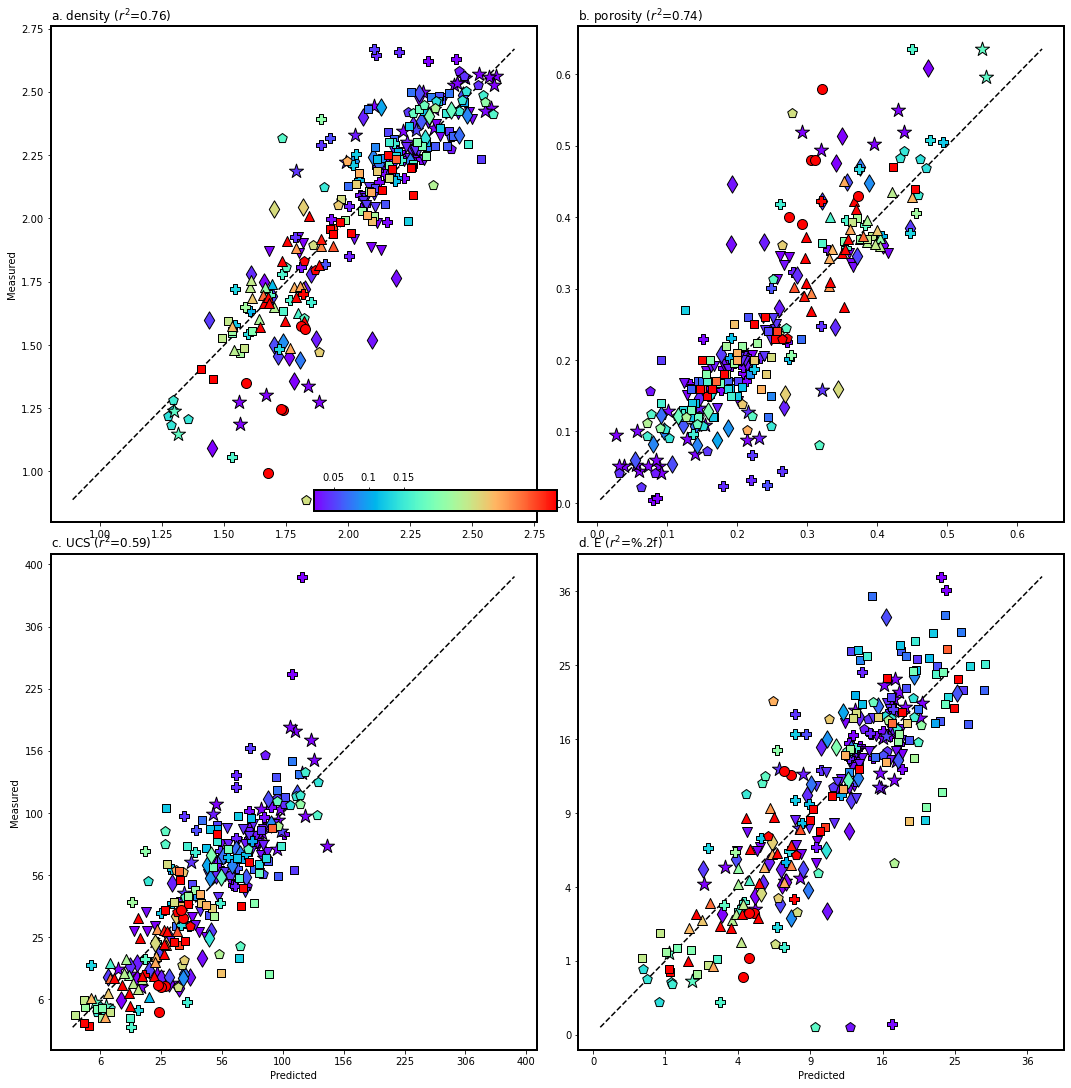

In [11]:
n = 'multi_svr_pca' # '256x4_multi_pca' # which model to plot

ks = M.models[n].fit_output['kfold_score_all']
titles = ['a. density ($r^2$=%.2f)'%ks[0], 'b. porosity ($r^2$=%.2f)'%ks[1], 'c. UCS ($r^2$=%.2f)'%ks[2], 'd. E ($r^2$=%.2f)']


# define symbology for each volcano
s = {'Copahue':'d','Cracked Mountain':'^','Deception Island':'X','La Soufriere':'s','Ruapehu':'P',
     'Ohakuri':'o','Other':'.','Tongariro':'*','Volvic':'v','Whakaari':'p'}
sz = {'*':2.2,'d':1.5,'p':1.,'+':2, 's':0.8} # adjust default marker size so they are more perceptually uniform

y_pred = M.models[n].ycv_ # prediction
ids = indices['sample_id'][ S.valid[:,0] ] # sample IDS
volcs = indices['volcanoes'][ S.valid[:,0] ] # volcano name

# sort out colours
cvar = indices['hydration'][ S.valid[:,0] ]
#cvar = indices['fmi'][ S.valid[:,0] ]
#cvar = S.y()[:,1] # porosity
vmin,vmax = np.percentile(cvar,(10,90))

# do plot!
fig,ax = plt.subplots(2,2, figsize=(15,15))


# labels etc.
ax[1,0].set_xlabel("Predicted")
ax[1,1].set_xlabel("Predicted")
ax[0,0].set_ylabel("Measured")
ax[1,0].set_ylabel("Measured")

fig.tight_layout()

# plot
for i,a in enumerate(ax.ravel()):
    for v in np.unique(volcs):
        # get volcano symbol
        _s = s.get(v, s['Other'])
        _sz = 100*sz.get(_s,1)
    
        # get mask of the points that belong to this volcano
        mask = volcs == v

        # plot
        for j in range(np.sum(mask)):
            _x = M.models[n].ycv_[mask,i][j]
            _y = M.stack.y()[mask,i][j]
            if i >= 2:
                _x = np.sqrt(_x)
                _y = np.sqrt(_y)
            cm = a.scatter( _x, _y, 
                        c=cvar[mask][j], alpha=1., vmin=vmin, vmax=vmax, cmap='rainbow',
                        edgecolors='k', marker=_s, s=_sz, zorder=cvar[mask][j] ) # bring high values to front
        
        a.set_title(titles[i],loc='left')
        ax[0,0].scatter( np.nan, np.nan, c='k', marker=_s, s=_sz, label=v  )  # plot for legend
    # plot 1:1 line
    if i >= 2:
        _r = [np.min( [np.sqrt(M.models[n].ycv_[:,i]), np.sqrt(M.stack.y()[:,i] )]), 
              np.max( [np.sqrt(M.models[n].ycv_[:,i]), np.sqrt(M.stack.y()[:,i] )])]
        a.plot(_r,_r,color='k',ls='--',zorder=0)
        a.set_xticklabels(["%d"%(x**2) for x in a.get_xticks()])
        a.set_yticklabels(["%d"%(y**2) for y in a.get_yticks()])
    else:
        _r = [np.min( [M.models[n].ycv_[:,i], M.stack.y()[:,i] ]), np.max( [M.models[n].ycv_[:,i], M.stack.y()[:,i] ])]
        a.plot(_r,_r,color='k',ls='--',zorder=0)


# Create colorbar in the top-right corner of each axis
ax_bbox = ax[0,0].get_position()
w = 0.5
cbar_width = w * ax_bbox.width  # Reduce width of the colorbar
cbar_height = 0.02  # Height of the colorbar
#cbar_x = ax_bbox.width  - 0.06  # Offset to the lower left
#cbar_y = ax_bbox.y1 - ax_bbox.height + 0.05  # Slightly above the plot
cbar_x = ax_bbox.width - 0.36*ax_bbox.width   # Offset to the lower left
cbar_y = ax_bbox.y1 - ax_bbox.height + 0.01  # Slightly above the plot

# Create a new axis for the colorbar
cbar_ax = fig.add_axes([cbar_x, cbar_y, cbar_width, cbar_height])
cb = Colorbar(cbar_ax, cm, orientation="horizontal")

cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.set_xticks([0.05, 0.1, 0.15])
cb.ax.set_xticklabels(["0.05", "0.1", "0.15"])
fig.show()